## Pumpkin Seed Quality Prediction Model
### Individual Assignment Tabea Herbst

In [1]:
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
# ^^^ pyforest auto-imports - don't write above this line


In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer
from scipy.stats import uniform, randint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [38]:
seeds = pd.read_csv("Pumpkin_Seeds_Dataset.csv",  sep = ";", decimal = ",")

In [5]:
seeds.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class
0,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,Çerçevelik
1,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,Çerçevelik
2,71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,Çerçevelik
3,66458,992.051,381.5638,222.5322,67118,290.8899,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624,Çerçevelik
4,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,Çerçevelik


In [6]:
seeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               2500 non-null   int64  
 1   Perimeter          2500 non-null   float64
 2   Major_Axis_Length  2500 non-null   float64
 3   Minor_Axis_Length  2500 non-null   float64
 4   Convex_Area        2500 non-null   int64  
 5   Equiv_Diameter     2500 non-null   float64
 6   Eccentricity       2500 non-null   float64
 7   Solidity           2500 non-null   float64
 8   Extent             2500 non-null   float64
 9   Roundness          2500 non-null   float64
 10  Aspect_Ration      2500 non-null   float64
 11  Compactness        2500 non-null   float64
 12  Class              2500 non-null   object 
dtypes: float64(10), int64(2), object(1)
memory usage: 254.0+ KB


In [7]:
seeds.describe()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,80658.220800,1130.279015,456.601840,225.794921,81508.084400,319.334230,0.860879,0.989492,0.693205,0.791533,2.041702,0.704121
std,13664.510228,109.256418,56.235704,23.297245,13764.092788,26.891920,0.045167,0.003494,0.060914,0.055924,0.315997,0.053067
min,47939.000000,868.485000,320.844600,152.171800,48366.000000,247.058400,0.492100,0.918600,0.468000,0.554600,1.148700,0.560800
25%,70765.000000,1048.829750,414.957850,211.245925,71512.000000,300.167975,0.831700,0.988300,0.658900,0.751900,1.801050,0.663475
50%,79076.000000,1123.672000,449.496600,224.703100,79872.000000,317.305350,0.863700,0.990300,0.713050,0.797750,1.984200,0.707700
75%,89757.500000,1203.340500,492.737650,240.672875,90797.750000,338.057375,0.897025,0.991500,0.740225,0.834325,2.262075,0.743500
max,136574.000000,1559.450000,661.911300,305.818000,138384.000000,417.002900,0.948100,0.994400,0.829600,0.939600,3.144400,0.904900


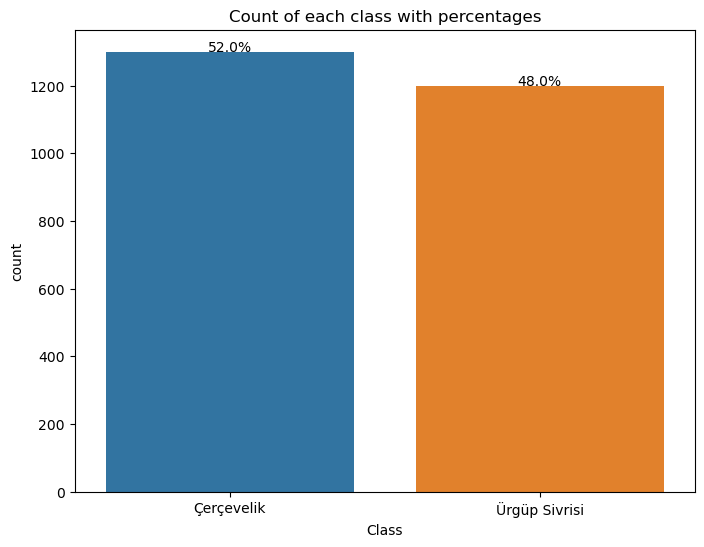

In [8]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Class', data=seeds)

total = len(seeds['Class'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(), percentage, ha='center')

# Show the plot
plt.title('Count of each class with percentages')
plt.show()

In [9]:
# Dataset is relatively equally balanced, no rebalancing needed

In [10]:
sns.pairplot(seeds, hue = 'Class', vars = ['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length','Convex_Area',  'Equiv_Diameter', 'Eccentricity', 'Solidity','Extent',  'Roundness', 'Aspect_Ration', 'Compactness'])

/var/folders/_v/58mr54p94pv96mqpmqpht5h40000gn/T/ipykernel_49507/759386849.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = seeds.corr()


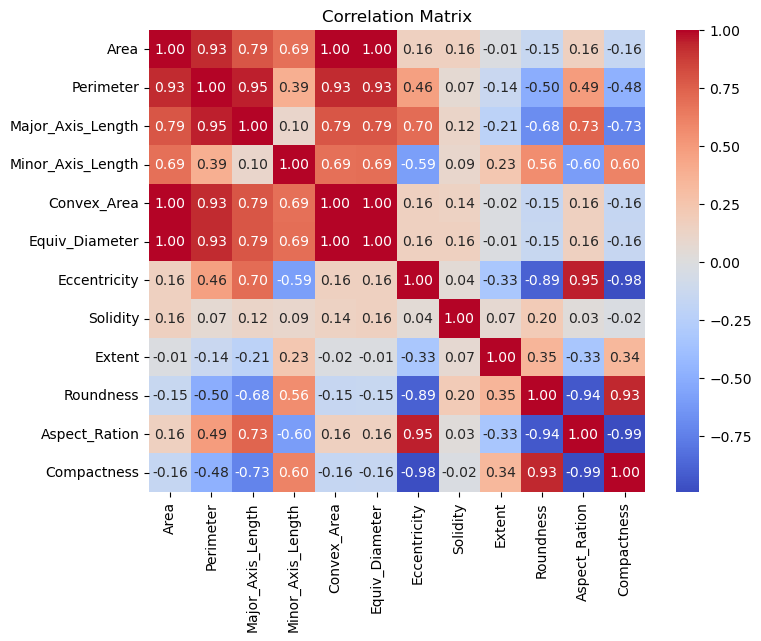

In [11]:
correlation_matrix = seeds.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [12]:
#As expected high correlations of many features, depending on model performance, some features will be discarded

In [13]:
#create batches for better Boxplot Depiction
seeds_batch1 = ['Area','Convex_Area']
seeds_batch2 = ['Eccentricity', 'Solidity','Extent',  'Roundness', 'Compactness']
seeds_batch3 = ['Major_Axis_Length', 'Minor_Axis_Length', 'Equiv_Diameter']
seeds_batch4 = ['Aspect_Ration']
seeds_batch5 = ['Perimeter']

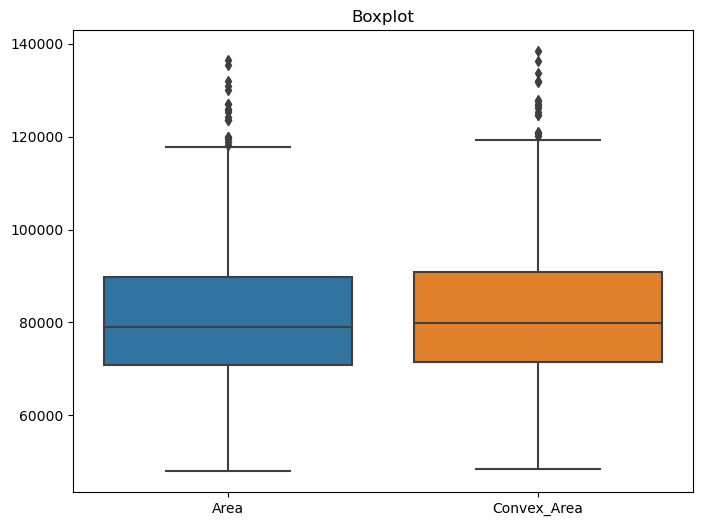

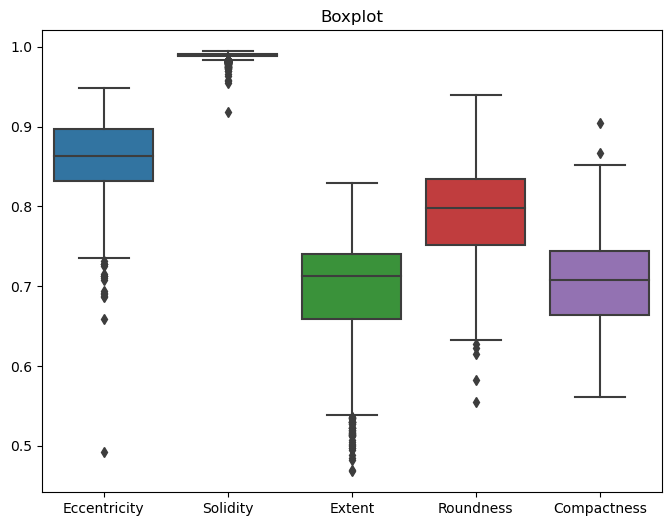

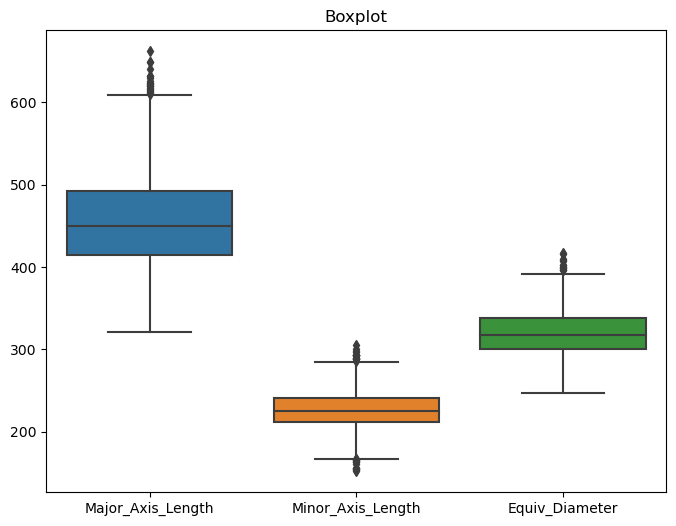

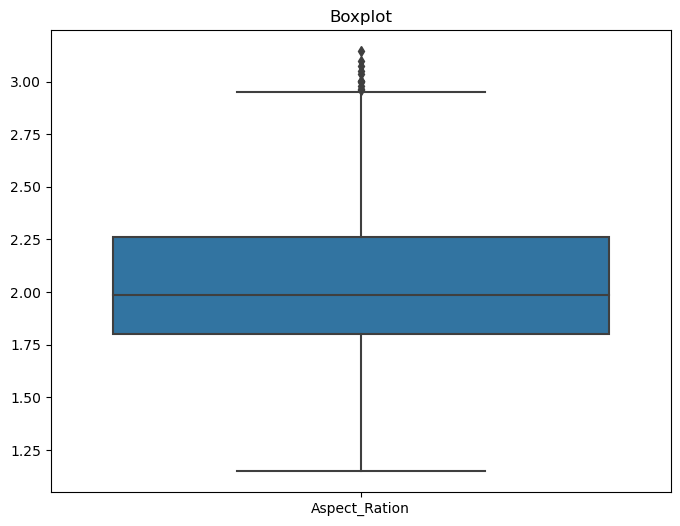

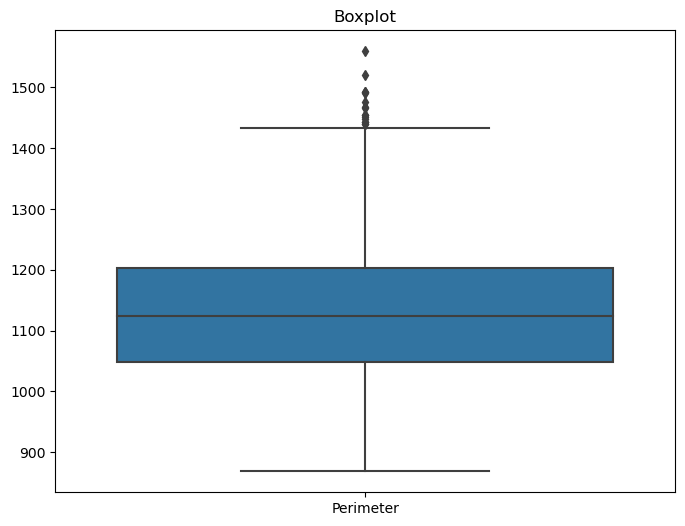

In [14]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=seeds[seeds_batch1])
plt.title("Boxplot")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=seeds[seeds_batch2])
plt.title("Boxplot")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=seeds[seeds_batch3])
plt.title("Boxplot")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=seeds[seeds_batch4])
plt.title("Boxplot")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=seeds[seeds_batch5])
plt.title("Boxplot")
plt.show()

In [15]:
# One very far outlier in Eccentricity 

In [16]:
seeds["Eccentricity"].describe()

count    2500.000000
mean        0.860879
std         0.045167
min         0.492100
25%         0.831700
50%         0.863700
75%         0.897025
max         0.948100
Name: Eccentricity, dtype: float64

### Preprocessing

In [17]:
#change some incorrect datatypes
seeds['Area'] = seeds['Area'].astype(float) 
seeds['Convex_Area'] = seeds['Convex_Area'].astype(float) 

In [18]:
eccentricity_outlier = seeds['Eccentricity'].idxmax()

# drop the row with the extreme value in "Eccentricity"
seeds = seeds.drop(index=eccentricity_outlier)

In [41]:
#Encode  the target feature into binary values
target_values = seeds['Class']
label_encoder = LabelEncoder()
# Fit and transform the target variable
seeds['Target'] = label_encoder.fit_transform(target_values)

In [20]:
seeds.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class,Target
0,56276.0,888.242,326.1485,220.2388,56831.0,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,Çerçevelik,0
1,76631.0,1068.146,417.1932,234.2289,77280.0,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,Çerçevelik,0
2,71623.0,1082.987,435.8328,211.0457,72663.0,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,Çerçevelik,0
3,66458.0,992.051,381.5638,222.5322,67118.0,290.8899,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624,Çerçevelik,0
4,66107.0,998.146,383.8883,220.4545,67117.0,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,Çerçevelik,0


In [33]:
seeds_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2499 entries, 0 to 2499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Major_Axis_Length  2499 non-null   float64
 1   Minor_Axis_Length  2499 non-null   float64
 2   Eccentricity       2499 non-null   float64
 3   Solidity           2499 non-null   float64
 4   Extent             2499 non-null   float64
 5   Roundness          2499 non-null   float64
 6   Aspect_Ration      2499 non-null   float64
 7   Compactness        2499 non-null   float64
 8   Target             2499 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 195.2 KB


In [21]:
#after several iterations of tuning these features have shown to decrease model performance and will therefore be dropped
columns_to_drop = ["Class", "Perimeter", "Area", "Equiv_Diameter", "Convex_Area"]
seeds_final = seeds.drop(columns=columns_to_drop, axis=1)

In [22]:
seeds_final.head()

,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Target
0,326.1485,220.2388,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,0
1,417.1932,234.2289,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,0
2,435.8328,211.0457,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,0
3,381.5638,222.5322,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624,0
4,383.8883,220.4545,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,0


In [23]:
#Separating Target and Features 
X = seeds_final.drop('Target', axis=1)
y = seeds_final['Target']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
X_train.shape

(1999, 8)

In [36]:
y_train.shape

(1999,)

In [37]:
y_test.shape

(500,)

### Model Training

In [25]:
# Create an XGBoost classifier
xgb_model = XGBClassifier()

# Define the parameter grid for grid search
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [26]:
# Create a GridSearchCV object
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, scoring='accuracy', cv=3, random_state=42)

# Fit the random search to the data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='accuracy')

In [27]:
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [28]:
# Print the results
print("Best Parameters:", best_params)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Accuracy: 0.87
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87       249
           1       0.89      0.84      0.87       251

    accuracy                           0.87       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500



<Axes: >

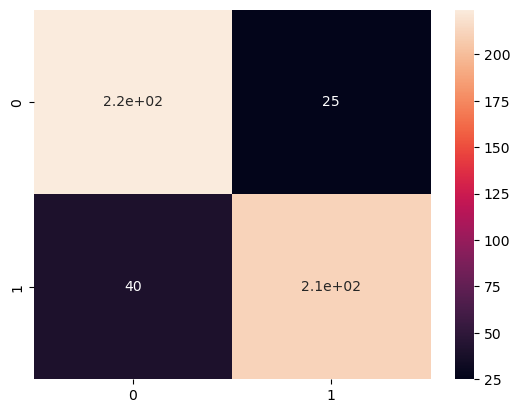

In [29]:
sns.heatmap(conf_matrix, annot=True)

Feature Importances:
             Feature  Importance
6      Aspect_Ration    0.455471
2       Eccentricity    0.224463
7        Compactness    0.194655
0  Major_Axis_Length    0.033730
1  Minor_Axis_Length    0.029156
3           Solidity    0.028636
5          Roundness    0.018720
4             Extent    0.015168


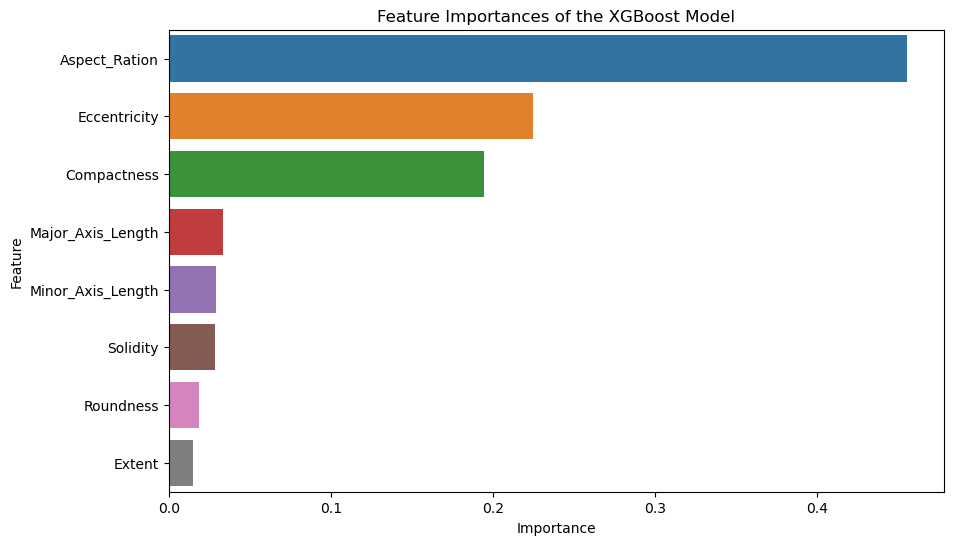

In [30]:
# Access feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances of the XGBoost Model')
plt.show()

In [31]:
import joblib

In [32]:
joblib.dump(best_model, 'Pumpkin_Model.pkl')

['Pumpkin_Model.pkl']